# **Revisited Project EDA**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import pyspark as ps
import pandas as pd
from pyspark.sql.functions import lit

In [2]:
# importer from capstone 1

class PipelineToPandas():
    '''
    Class that performs ETL from datalake json file to structured pandas dataframe, then to local csv.
    '''
    def __init__(self):
        self.spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
        self.sc = self.spark.sparkContext

    def spark_df_to_pandas(self, path_to_json, from_state, search_term_key):
        spark_df = self.spark.read.format('json').load(path_to_json)
        self.json_attributes = ['id','user','lang','entities','place','created_at','text','source']
        truncated_spark_df = spark_df[self.json_attributes]
        
        truncated_spark_df = truncated_spark_df.withColumn('state',lit(from_state))
        truncated_spark_df = truncated_spark_df.withColumn('search_term_key',lit(search_term_key))
        truncated_spark_df.createOrReplaceTempView('sql_temp_table')

        self.new_spark_df = self.spark.sql('''
            SELECT 
                id AS tweet_id,
                state,
                search_term_key,
                user.`id` AS user_id,
                created_at AS time_created,
                text AS tweet_text,
                source,
                place.`full_name` AS geo_name,
                place.`id` AS geo_id,
                place.`bounding_box`.`coordinates`[0][0][1] AS geo_coords_SW_lat,
                place.`bounding_box`.`coordinates`[0][0][0] AS geo_coords_SW_long,
                place.`bounding_box`.`coordinates`[0][2][1] AS geo_coords_NE_lat,
                place.`bounding_box`.`coordinates`[0][2][0] AS geo_coords_NE_long,
                entities.`hashtags`[0].`text` AS hash_tag_1,
                entities.`hashtags`[1].`text` AS hash_tag_2,
                entities.`hashtags`[2].`text` AS hash_tag_3,
                entities.`hashtags`[3].`text` AS hash_tag_4,
                entities.`hashtags`[4].`text` AS hash_tags_5,
                entities.`user_mentions`[0].`screen_name` AS user_mentions_1,
                entities.`user_mentions`[1].`screen_name` AS user_mentions_2,
                entities.`user_mentions`[2].`screen_name` AS user_mentions_3,
                entities.`user_mentions`[3].`screen_name` AS user_mentions_4,
                entities.`user_mentions`[4].`screen_name` AS user_mentions_5,
                user.`created_at` AS user_date_created,
                user.`location` AS location,
                user.`description` AS description
            FROM sql_temp_table
            WHERE
                lang = 'en'
            ''')
        self.pandas_df = self.new_spark_df.toPandas()

    def save_to_csv(self, path_to_csv):
        self.pandas_df.to_csv(path_to_csv, encoding='utf-8')

In [6]:
# going to look at individual tweet to see structure

df = pd.read_json('../data/AR/1_agg.json', orient='records', lines=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 10100 non-null  datetime64[ns, UTC]
 1   id                         10100 non-null  int64              
 2   id_str                     10100 non-null  int64              
 3   text                       10100 non-null  object             
 4   display_text_range         4533 non-null   object             
 5   source                     10100 non-null  object             
 6   truncated                  10100 non-null  bool               
 7   in_reply_to_status_id      4363 non-null   float64            
 8   in_reply_to_status_id_str  4363 non-null   float64            
 9   in_reply_to_user_id        4577 non-null   float64            
 10  in_reply_to_user_id_str    4577 non-null   float64            
 11  in

In [10]:
# lots of columsn, lets look at them in chunks
# first 7

df_1 = df[df.columns[:7]]
df_1.head()

,created_at,id,id_str,text,display_text_range,source,truncated
0,2020-04-05 16:04:08+00:00,1246830992616239105,1246830992616239104,@ajwritesxx Gracias!!!,"[12, 22]","<a href=""http://twitter.com/download/iphone"" r...",False
1,2020-04-05 16:04:08+00:00,1246830993903955968,1246830993903955968,"lil pump really said ""look at my wrist corona ...",NaN,"<a href=""http://twitter.com/download/android"" ...",False
2,2020-04-05 16:04:08+00:00,1246830994537222144,1246830994537222144,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,"[40, 126]","<a href=""http://twitter.com/download/android"" ...",False
3,2020-04-05 16:04:08+00:00,1246830995132813312,1246830995132813312,RT @Jali_Cat: Yet you’ve been in office since ...,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False
4,2020-04-05 16:04:09+00:00,1246830995761963008,1246830995761963008,@JoeBiden This is a better message and more co...,"[10, 87]","<a href=""http://twitter.com/#!/download/ipad"" ...",False


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          10100 non-null  datetime64[ns, UTC]
 1   id                  10100 non-null  int64              
 2   id_str              10100 non-null  int64              
 3   text                10100 non-null  object             
 4   display_text_range  4533 non-null   object             
 5   source              10100 non-null  object             
 6   truncated           10100 non-null  bool               
dtypes: bool(1), datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 483.4+ KB


In [24]:
df_1['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
       '<a href="https://buffer.com" rel="nofollow">Buffer</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://www.careerarc.com" rel="nofollow">CareerArc 2.0</a>',
       '<a href="http://txpub.usgs.gov/txwaterdashboard/" rel="nofollow">CWIS Twitter Feed</a>',
       '<a href="http://klinkerapps.com" rel="nofollow">Talon Android</a>',
       '<a href="https://twitterrific.com/ios" rel="nofollow">Twitterrific for i

In [48]:
# create a list of cols to drop..
drop_lst = ['id_str']


In [33]:
df_2 = df[df.columns[7:14]]
df_2.head()

,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo
0,1.246830e+18,1.246830e+18,9.157608e+17,9.157608e+17,ajwritesxx,"{'id': 95382124, 'id_str': '95382124', 'name':...",None
1,NaN,NaN,NaN,NaN,None,"{'id': 29214401, 'id_str': '29214401', 'name':...",None
2,1.246568e+18,1.246568e+18,9.816923e+17,9.816923e+17,Stephan59177054,"{'id': 4766479674, 'id_str': '4766479674', 'na...",None
3,NaN,NaN,NaN,NaN,None,"{'id': 3166145611, 'id_str': '3166145611', 'na...",None
4,1.246811e+18,1.246811e+18,9.390910e+05,9.390910e+05,JoeBiden,"{'id': 2868989345, 'id_str': '2868989345', 'na...",None


In [47]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   in_reply_to_status_id      4363 non-null   float64
 1   in_reply_to_status_id_str  4363 non-null   float64
 2   in_reply_to_user_id        4577 non-null   float64
 3   in_reply_to_user_id_str    4577 non-null   float64
 4   in_reply_to_screen_name    4577 non-null   object 
 5   user                       10100 non-null  object 
 6   geo                        36 non-null     object 
dtypes: float64(4), object(3)
memory usage: 552.5+ KB


In [53]:
# can drop _id_strs and keep _ids
drop_lst.extend(['in_reply_to_status_id_str', 'in_reply_to_user_id_str'])
drop_lst

['id', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str']

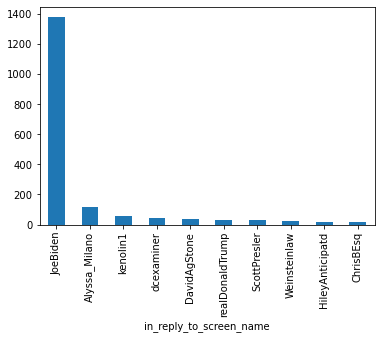

In [46]:
df_2.groupby('in_reply_to_screen_name').count().sort_values('user', ascending=False)['user'][:10].plot(kind='bar')
plt.show()

In [64]:
df_3 = df[df.columns[14:21]]
df_3.head()

,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count
0,None,"{'id': '31bb014b56203c53', 'url': 'https://api...",NaN,False,0,0,0
1,None,"{'id': '2526edd24c06e60c', 'url': 'https://api...",NaN,False,0,0,0
2,None,None,NaN,True,0,0,0
3,None,None,NaN,True,0,0,0
4,None,None,NaN,False,0,0,0


In [65]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   coordinates      36 non-null     object 
 1   place            1769 non-null   object 
 2   contributors     0 non-null      float64
 3   is_quote_status  10100 non-null  bool   
 4   quote_count      10100 non-null  int64  
 5   reply_count      10100 non-null  int64  
 6   retweet_count    10100 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 483.4+ KB


In [67]:
df_4 = df[df.columns[21:28]]
df_4.head()

,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms
0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,es,2020-04-05 16:04:08.296
1,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:08.603
2,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,2020-04-05 16:04:08.754
3,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:08.896
4,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:09.046


In [68]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   favorite_count  10100 non-null  int64         
 1   entities        10100 non-null  object        
 2   favorited       10100 non-null  bool          
 3   retweeted       10100 non-null  bool          
 4   filter_level    10100 non-null  object        
 5   lang            10100 non-null  object        
 6   timestamp_ms    10100 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(1), object(3)
memory usage: 414.4+ KB


In [69]:
df_5 = df[df.columns[28:]]
df_5.head()

,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,possibly_sensitive,retweeted_status,extended_entities,extended_tweet
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.246806e+18,1.246806e+18,{'created_at': 'Sun Apr 05 14:25:12 +0000 2020...,"{'url': 'https://t.co/IE9JWzLbGo', 'expanded':...",0.0,NaN,NaN,NaN
3,1.245421e+18,1.245421e+18,{'created_at': 'Wed Apr 01 18:41:00 +0000 2020...,"{'url': 'https://t.co/pDE8xNjbsu', 'expanded':...",NaN,{'created_at': 'Fri Apr 03 00:33:50 +0000 2020...,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quoted_status_id         2038 non-null   float64
 1   quoted_status_id_str     2038 non-null   float64
 2   quoted_status            2037 non-null   object 
 3   quoted_status_permalink  2037 non-null   object 
 4   possibly_sensitive       1594 non-null   float64
 5   retweeted_status         4091 non-null   object 
 6   extended_entities        826 non-null    object 
 7   extended_tweet           2016 non-null   object 
dtypes: float64(3), object(5)
memory usage: 631.4+ KB


In [71]:
drop_lst.append('quoted_status_id_str')

In [72]:
df_4['entities'][0]

{'hashtags': [],
 'urls': [],
 'user_mentions': [{'screen_name': 'ajwritesxx',
   'name': 'AJ 🅴',
   'id': 915760801067147265,
   'id_str': '915760801067147265',
   'indices': [0, 11]}],
 'symbols': []}

In [76]:
df_2['user'][1000].get('id')

1148395669322780672

In [77]:
df_1['id'][1000]

1246947454966267906

In [78]:
from bs4 import BeautifulSoup

In [85]:
soup = BeautifulSoup(df_1['source'][0])

In [86]:
soup

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>

In [97]:
soup.find('a').getText()

'Twitter for iPhone'

In [99]:
source = df_1['source'].apply(lambda x: BeautifulSoup(x).find('a').getText())

In [112]:
df_1['source_txt'] = source

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
df_1.drop('source', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [116]:
df_1.head()

,created_at,id,id_str,text,display_text_range,truncated,source_txt
0,2020-04-05 16:04:08+00:00,1246830992616239105,1246830992616239104,@ajwritesxx Gracias!!!,"[12, 22]",False,Twitter for iPhone
1,2020-04-05 16:04:08+00:00,1246830993903955968,1246830993903955968,"lil pump really said ""look at my wrist corona ...",NaN,False,Twitter for Android
2,2020-04-05 16:04:08+00:00,1246830994537222144,1246830994537222144,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,"[40, 126]",False,Twitter for Android
3,2020-04-05 16:04:08+00:00,1246830995132813312,1246830995132813312,RT @Jali_Cat: Yet you’ve been in office since ...,NaN,False,Twitter Web App
4,2020-04-05 16:04:09+00:00,1246830995761963008,1246830995761963008,@JoeBiden This is a better message and more co...,"[10, 87]",False,Twitter for iPad


In [119]:
df_1.groupby('source_txt').count().sort_values('id',ascending=False)

,created_at,id,id_str,text,display_text_range,truncated
source_txt,,,,,,
Twitter for iPhone,4572,4572,4572,4572,2039,4572
Twitter for Android,2619,2619,2619,2619,1264,2619
Twitter Web App,2221,2221,2221,2221,1006,2221
Twitter for iPad,521,521,521,521,181,521
Twitter Web Client,59,59,59,59,22,59
TweetDeck,29,29,29,29,11,29
Instagram,21,21,21,21,0,21
CareerArc 2.0,8,8,8,8,0,8
Twitterrific for iOS,6,6,6,6,1,6


In [120]:
df_1['test'] = 'test'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          10100 non-null  datetime64[ns, UTC]
 1   id                  10100 non-null  int64              
 2   id_str              10100 non-null  int64              
 3   text                10100 non-null  object             
 4   display_text_range  4533 non-null   object             
 5   truncated           10100 non-null  bool               
 6   source_txt          10100 non-null  object             
 7   test                10100 non-null  object             
dtypes: bool(1), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 562.3+ KB


In [131]:
df_test = pd.concat([df_1,df_1], ignore_index=True)

In [133]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          20200 non-null  datetime64[ns, UTC]
 1   id                  20200 non-null  int64              
 2   id_str              20200 non-null  int64              
 3   text                20200 non-null  object             
 4   display_text_range  9066 non-null   object             
 5   truncated           20200 non-null  bool               
 6   source_txt          20200 non-null  object             
 7   test                20200 non-null  object             
dtypes: bool(1), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 1.1+ MB


In [139]:
test = {1:'lol',2:'lpdlaf'}
for key in test.keys():
    print(key)


1
2


In [140]:
test = 0
test1 = 1
if (test ==0 and test1 ==1):
    print('hi')

hi


In [153]:
from datetime import datetime
str(datetime.now()).replace(' ', '_')

'2020-08-10_02:54:43.248109'

In [154]:
df_1.head()

,created_at,id,id_str,text,display_text_range,truncated,source_txt,test
0,2020-04-05 16:04:08+00:00,1246830992616239105,1246830992616239104,@ajwritesxx Gracias!!!,"[12, 22]",False,Twitter for iPhone,test
1,2020-04-05 16:04:08+00:00,1246830993903955968,1246830993903955968,"lil pump really said ""look at my wrist corona ...",NaN,False,Twitter for Android,test
2,2020-04-05 16:04:08+00:00,1246830994537222144,1246830994537222144,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,"[40, 126]",False,Twitter for Android,test
3,2020-04-05 16:04:08+00:00,1246830995132813312,1246830995132813312,RT @Jali_Cat: Yet you’ve been in office since ...,NaN,False,Twitter Web App,test
4,2020-04-05 16:04:09+00:00,1246830995761963008,1246830995761963008,@JoeBiden This is a better message and more co...,"[10, 87]",False,Twitter for iPad,test


In [155]:
df_2.head()

,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo
0,1.246830e+18,1.246830e+18,9.157608e+17,9.157608e+17,ajwritesxx,"{'id': 95382124, 'id_str': '95382124', 'name':...",None
1,NaN,NaN,NaN,NaN,None,"{'id': 29214401, 'id_str': '29214401', 'name':...",None
2,1.246568e+18,1.246568e+18,9.816923e+17,9.816923e+17,Stephan59177054,"{'id': 4766479674, 'id_str': '4766479674', 'na...",None
3,NaN,NaN,NaN,NaN,None,"{'id': 3166145611, 'id_str': '3166145611', 'na...",None
4,1.246811e+18,1.246811e+18,9.390910e+05,9.390910e+05,JoeBiden,"{'id': 2868989345, 'id_str': '2868989345', 'na...",None


In [156]:
df_3.head()

,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count
0,None,"{'id': '31bb014b56203c53', 'url': 'https://api...",NaN,False,0,0,0
1,None,"{'id': '2526edd24c06e60c', 'url': 'https://api...",NaN,False,0,0,0
2,None,None,NaN,True,0,0,0
3,None,None,NaN,True,0,0,0
4,None,None,NaN,False,0,0,0


In [157]:
df_4.head()

,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms
0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,es,2020-04-05 16:04:08.296
1,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:08.603
2,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,2020-04-05 16:04:08.754
3,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:08.896
4,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,2020-04-05 16:04:09.046


In [158]:
df_5.head()

,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,possibly_sensitive,retweeted_status,extended_entities,extended_tweet
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.246806e+18,1.246806e+18,{'created_at': 'Sun Apr 05 14:25:12 +0000 2020...,"{'url': 'https://t.co/IE9JWzLbGo', 'expanded':...",0.0,NaN,NaN,NaN
3,1.245421e+18,1.245421e+18,{'created_at': 'Wed Apr 01 18:41:00 +0000 2020...,"{'url': 'https://t.co/pDE8xNjbsu', 'expanded':...",NaN,{'created_at': 'Fri Apr 03 00:33:50 +0000 2020...,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
df_1['text'][4]

'@JoeBiden This is a better message and more constructive than blaming Trump. Thank you.'

In [207]:
start, end = df_1['display_text_range'][4]
start

10

In [208]:
df_1['text'][4][start:end]

'This is a better message and more constructive than blaming Trump. Thank you.'

In [210]:
df_5['quoted_status'][2]

{'created_at': 'Sun Apr 05 14:25:12 +0000 2020',
 'id': 1246806094401470464,
 'id_str': '1246806094401470464',
 'text': 'Health care insurers expected to raise premiums by as much as 40% to recoup coronavirus losses https://t.co/AUAbiFGfrE',
 'source': '<a href="https://ifttt.com" rel="nofollow">IFTTT</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 16955991,
  'id_str': '16955991',
  'name': 'Salon',
  'screen_name': 'Salon',
  'location': None,
  'url': 'https://www.salon.com/2018/10/26/the-new-ad-free-salon-subscribe-today-to-turn-off-ads/',
  'description': 'The original online source for news, politics and entertainment. \n\n We’re on Instagram: salonofficial',
  'translator_type': 'none',
  'protected': False,
  'verified': True,
  'followers_count': 974418,
  'friends_count': 5774,
  'listed_count': 15741,
  'favourites_c